# ZSWIM6

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.9.2


### ZSWIM6
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZSWIM6.

In [2]:
gene_symbol = 'ZSWIM6'
mane_tx_id = 'NM_020928.2'
mane_protein_id = 'NP_001685.1' # zinc finger SWIM domain-containing protein 6 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 16/16 [00:00<00:00, 264.50 individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #14
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
13,Global developmental delay
9,Hypertelorism
8,Bifid nose
7,Intellectual disability
7,Hypotonia
6,Unsteady gait
6,Absent speech
6,Midline central nervous system lipomas
5,Happy demeanor
5,Autistic behavior


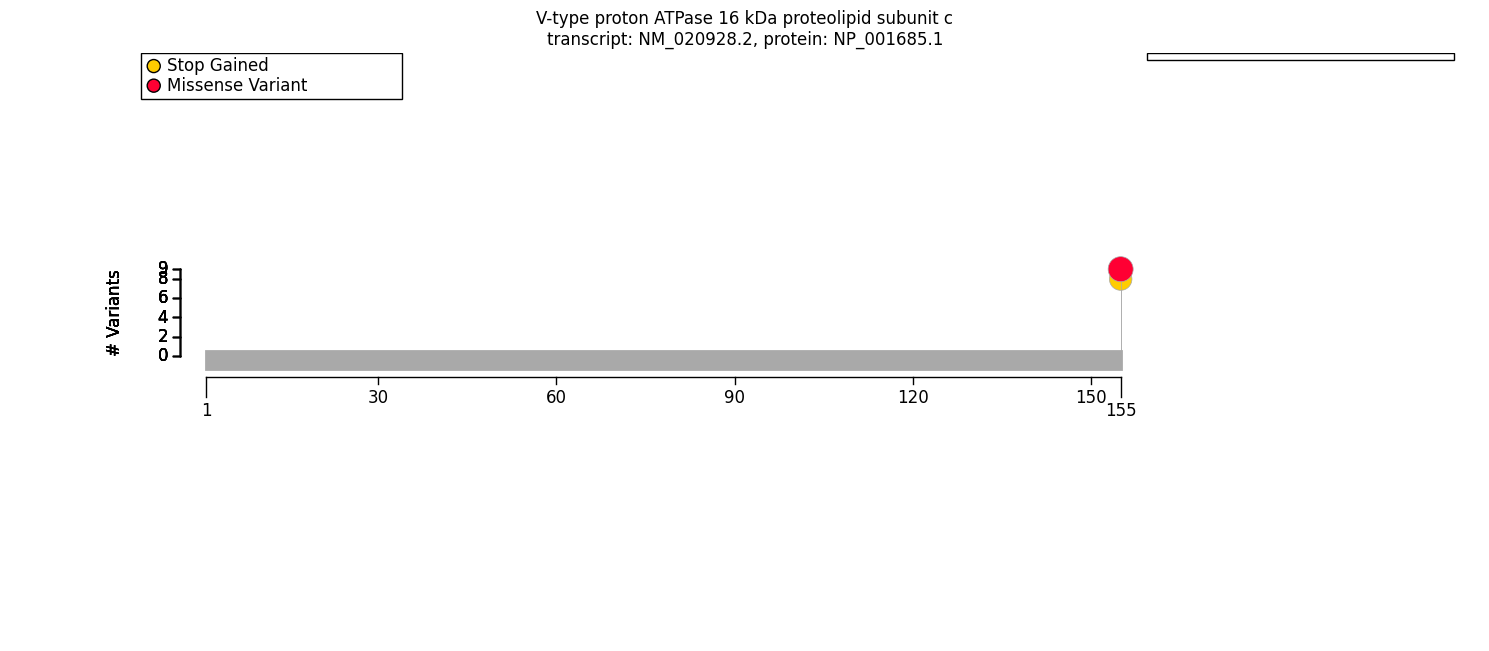

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

zswim6_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
zswim6_fig.tight_layout()

## Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_key

r913ter = variant_key("5_61541917_61541917_C_T") # c.2737C>T; p.Arg913Ter
r913w = variant_key("5_61544156_61544156_C_T")   # c.3487C>T; p.Arg1163Trp

r913_clf = monoallelic_classifier(
    a_predicate=r913ter, 
    b_predicate=r913w, 
    a_label="Arg913Ter", 
    b_label= "Arg1163Trp")
r913_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r913_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(r913_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,40
HMF03,Skipping term because of a child term with the same individual counts,6
HMF05,Skipping term because one genotype had zero observations,19
HMF08,Skipping general term,59
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,191


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=r913_result)

Allele group                                       Arg913Ter          \
                                                       Count Percent   
Abnormal cerebral morphology [HP:0002060]                5/5    100%   
Abnormal forebrain morphology [HP:0100547]               5/5    100%   
Abnormal brain morphology [HP:0012443]                   5/5    100%   
Morphological central nervous system abnormalit...       5/5    100%   
Aplasia/Hypoplasia involving the central nervou...       5/5    100%   
Neurodevelopmental abnormality [HP:0012759]              7/7    100%   
Neurodevelopmental delay [HP:0012758]                    7/7    100%   
Global developmental delay [HP:0001263]                  7/7    100%   
Abnormal ocular adnexa morphology [HP:0030669]           6/6    100%   
Abnormal oral cavity morphology [HP:0000163]             5/5    100%   
Abnormal nasal morphology [HP:0005105]                   1/1    100%   
Abnormal eyelid morphology [HP:0000492]                  3/3    100%   

Allele group                                       Arg1163Trp          \
                                                        Count Percent   
Abnormal cerebral morphology [HP:0002060]                 3/3    100%   
Abnormal forebrain morphology [HP:0100547]                3/3    100%   
Abnormal brain morphology [HP:0012443]                    4/4    100%   
Morphological central nervous system abnormalit...        7/7    100%   
Aplasia/Hypoplasia involving the central nervou...        2/2    100%   
Neurodevelopmental abnormality [HP:0012759]               6/6    100%   
Neurodevelopmental delay [HP:0012758]                     6/6    100%   
Global developmental delay [HP:0001263]                   6/7     86%   
Abnormal ocular adnexa morphology [HP:0030669]            7/7    100%   
Abnormal oral cavity morphology [HP:0000163]              4/4    100%   
Abnormal nasal morphology [HP:0005105]                    9/9    100%   
Abnormal eyelid morphology [HP:0000492]                   7/7    100%   

Allele group                                                                    
                                                   Corrected p values p values  
Abnormal cerebral morphology [HP:0002060]                         1.0      1.0  
Abnormal forebrain morphology [HP:0100547]                        1.0      1.0  
Abnormal brain morphology [HP:0012443]                            1.0      1.0  
Morphological central nervous system abnormalit...                1.0      1.0  
Aplasia/Hypoplasia involving the central nervou...                1.0      1.0  
Neurodevelopmental abnormality [HP:0012759]                       1.0      1.0  
Neurodevelopmental delay [HP:0012758]                             1.0      1.0  
Global developmental delay [HP:0001263]                           1.0      1.0  
Abnormal ocular adnexa morphology [HP:0030669]                    1.0      1.0  
Abnormal oral cavity morphology [HP:0000163]                      1.0      1.0  
Abnormal nasal morphology [HP:0005105]                            1.0      1.0  
Abnormal eyelid morphology [HP:0000492]                           1.0      1.0

# Summary

In [9]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
    GPAnalysisResultSummary.from_multi(
        result=r913_result,
    ),
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [10]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Arg913Ter,Arg1163Trp,12,0


In [11]:
summarizer.process_latex(report=report, protein_fig=zswim6_fig)

Figure saved to ../../supplement/img/ZSWIM6_protein_diagram-draft.pdf
Output to ../../supplement/tex/ZSWIM6_summary_draft.tex
